In [1]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

def normalize_image_intensity(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    normalized_img = nib.Nifti1Image(normalized_data, img.affine, img.header)
    return normalized_img

def load_mris_and_labels(mri_directory, csv_file):
    df = pd.read_csv(csv_file)
    mris = []
    labels = []
    ids = []

    for filename in os.listdir(mri_directory):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            rsct_id = filename.split('_')[0].split('-')[1]  # Adjusted to match your filename format
            img = nib.load(os.path.join(mri_directory, filename))
            normalized_img = normalize_image_intensity(img)
            label = df.loc[df['record_id'] == rsct_id, 'surg_engel'].values[0]

            mris.append(normalized_img)
            labels.append(label)
            ids.append(rsct_id)

    return mris, labels, ids

def create_model(input_shape):
    """ Create a 3D CNN model with regularization. """
    inputs = Input(shape=input_shape)
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4)  # Lower learning rate
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

In [2]:
# Load the data
mris, labels, ids = load_mris_and_labels('../../scripts/flirt_bet', '../../data/processed/label_df.csv')

# Convert MRI data to numpy array
mris_array = np.array([mri.get_fdata() for mri in mris])[..., np.newaxis]

C:\Users\amaur\AppData\Local\Temp\ipykernel_25472\1172976028.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std


In [3]:
# Prepare the data
X = mris_array[:160]
y = np.array(labels)[:160]

# Convert labels to binary (1 if label is 1, else 0)
y = np.where(y == 1, 1, 0)

# Verify labels for the subset
#print(f'Labels for the first 20 samples: {y}')

# Define input shape for the model
input_shape = X.shape[1:]

# Create the model
model = create_model(input_shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the input data shape is correct
#print(f'X_train shape: {X_train.shape}')  # This should print (number of samples, 91, 109, 91, 1)
#print(f'y_train shape: {y_train.shape}')  # This should print (number of samples,)

# Fit the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=10)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5567 - auc: 0.4568 - loss: 22.0125 - val_accuracy: 0.3750 - val_auc: 0.5000 - val_loss: 0.7101
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5444 - auc: 0.4555 - loss: 0.7007 - val_accuracy: 0.3750 - val_auc: 0.5000 - val_loss: 0.6934
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.4984 - auc: 0.4538 - loss: 0.7029 - val_accuracy: 0.6250 - val_auc: 0.5000 - val_loss: 0.6661
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5858 - auc: 0.5296 - loss: 0.6876 - val_accuracy: 0.6250 - val_auc: 0.5000 - val_loss: 0.6619
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6161 - auc: 0.5068 - loss: 0.6780 - val_accuracy: 0.6250 - val_auc: 0.5000 - val_loss: 0.6621


In [5]:
print(shap.__version__)

0.44.1


In [6]:
import shap

# Create a SHAP DeepExplainer
explainer_gradient = shap.GradientExplainer(model, X_train[:50])
#explainer_deep = shap.DeepExplainer(model, X_train[:50])

#explainer_kernel = shap.KernelExplainer(BAPredictor.predict(brains[:50]), brains[:50])
#explainer_kernel = shap.KernelExplainer(BAPredictor, brains[:50])

In [7]:
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough
#tf.keras.backend.set_learning_phase(0)

# Compute SHAP values for a subset of the data
shap_values = explainer_gradient.shap_values(X_train[40:55])
#shap_values = explainer_deep.shap_values(brains[200:225])

AttributeError: in user code:

    File "c:\Users\amaur\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_gradient.py", line 217, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'


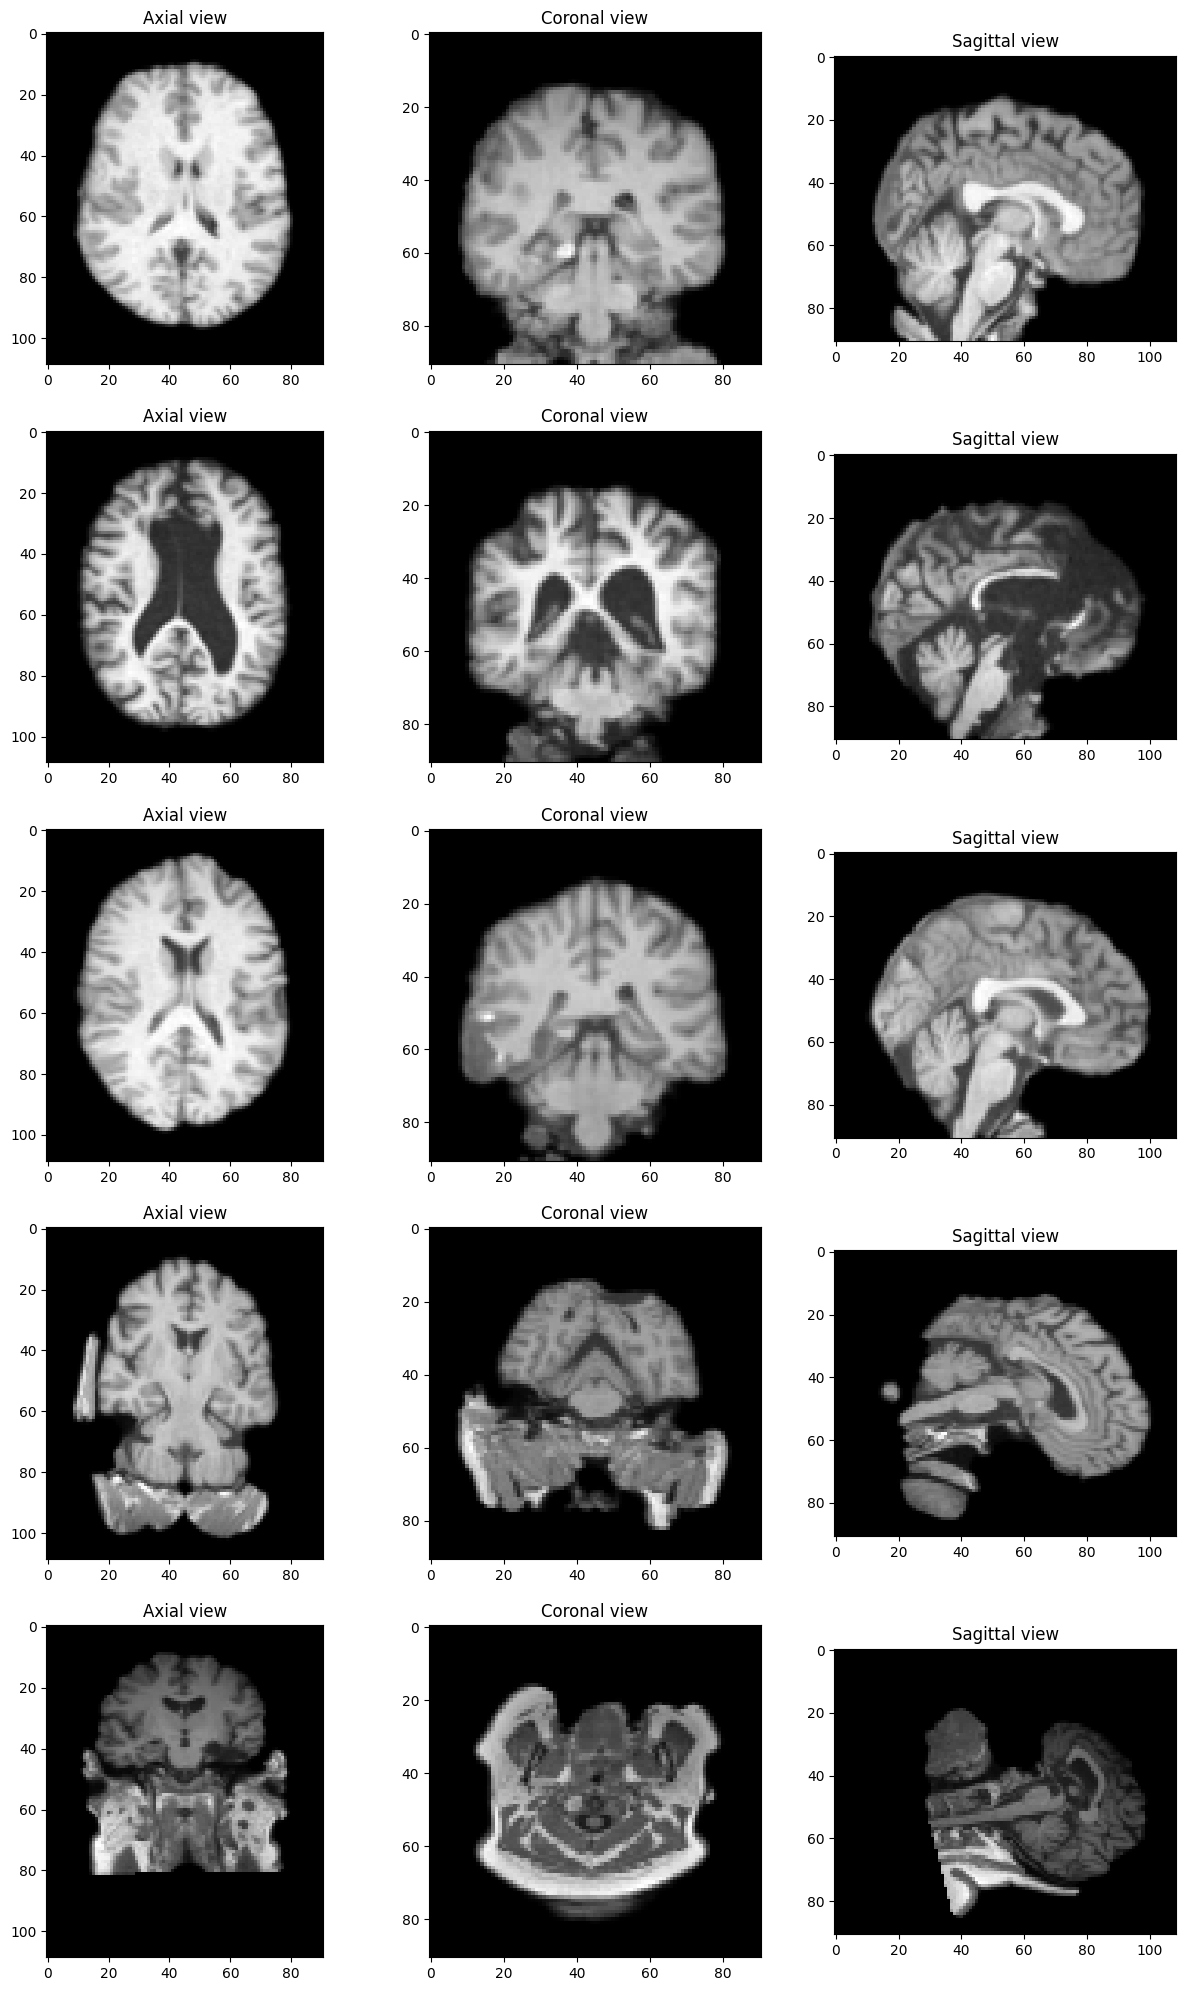

In [ ]:
import matplotlib.pyplot as plt

def show_mri_slices(mris, num_slices=5):
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5 * num_slices))
    for i in range(num_slices):
        data = mris[i].get_fdata()
        mid_slice = data.shape[2] // 2
        
        # Adjusting orientation by rotating 90 degrees counterclockwise
        axes[i, 0].imshow(np.rot90(data[:, :, mid_slice]), cmap='gray')
        axes[i, 0].set_title('Axial view')
        axes[i, 1].imshow(np.rot90(data[:, mid_slice, :]), cmap='gray')
        axes[i, 1].set_title('Coronal view')
        axes[i, 2].imshow(np.rot90(data[mid_slice, :, :]), cmap='gray')
        axes[i, 2].set_title('Sagittal view')
    
    plt.show()

# Show some MRI slices after normalization
show_mri_slices(mris)

In [4]:
# Save the model to a file
model.save('../../models/mri_cnn.h5')

from tensorflow.keras.models import load_model

# Load the model from the file
#loaded_model = load_model('../../models/mri_cnn.h5')


OSError: No file or directory found at ../../models/mri_cnn.h5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
True Label: 0, Prediction: 1


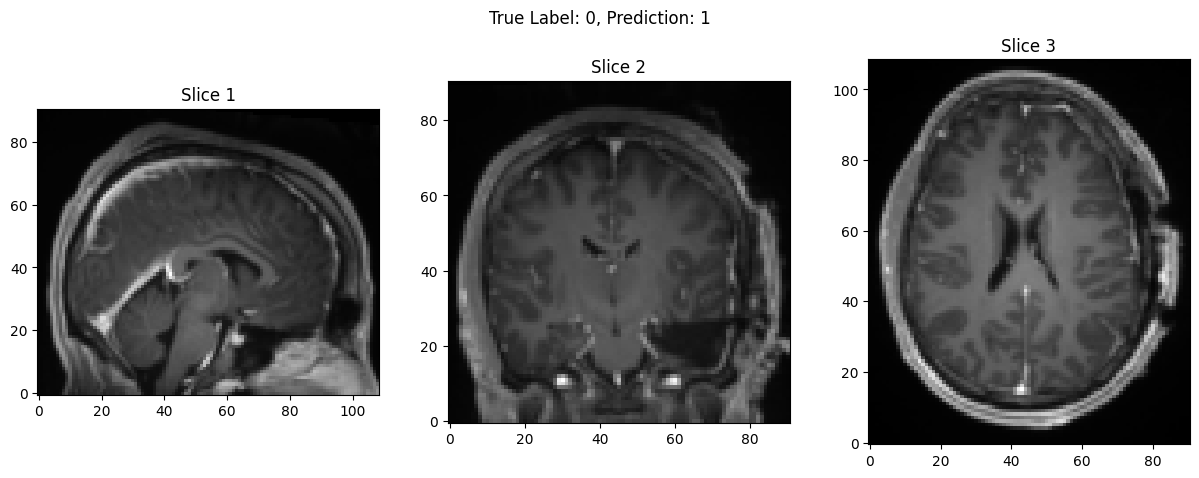

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)

# Since the output is a probability, convert it to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Select an example to visualize (e.g., the first example)
example_index = 0

# Get the MRI, true label, and prediction
mri_example = X_test[example_index]
true_label = y_test[example_index]
#true_label_multi = labels[example_index]
predicted_label = predicted_labels[example_index][0]

# Print the true label and prediction
print(f'True Label: {true_label}, Prediction: {predicted_label}')

# Plot the MRI slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Select three slices to visualize (middle slices of each dimension)
slices = [mri_example[mri_example.shape[0] // 2, :, :, 0],
          mri_example[:, mri_example.shape[1] // 2, :, 0],
          mri_example[:, :, mri_example.shape[2] // 2, 0]]

for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")
    axes[i].set_title(f'Slice {i+1}')

plt.suptitle(f'True Label: {true_label}, Prediction: {predicted_label}')
plt.show()

In [ ]:
import os
import pandas as pd
import nibabel as nib

def load_mris_and_labels(mri_directory, csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    mris = []
    labels = []
    ids = []

    for filename in os.listdir(mri_directory):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            # Extract the RSCT id from the filename
            rsct_id = filename.split('_')[0].split('-')[1]  # Adjusted to match your filename format

            # Load the MRI file
            img = nib.load(os.path.join(mri_directory, filename))

            # Find the corresponding label
            label = df.loc[df['record_id'] == rsct_id, 'surg_engel'].values[0]

            mris.append(img)
            labels.append(label)
            ids.append(rsct_id)

    return mris, labels, ids

# Usage
mris, labels, ids = load_mris_and_labels('../../scripts/flirt_raw', '../../data/processed/label_df.csv')

# Print the shape, ID, and surg_engel for the first 10 MRIs
for i in range(10):
    print(f'ID: {ids[i]}, Shape: {mris[i].shape}, surg_engel: {labels[i]}')

# MRI preprocessing

In [ ]:
import os
import pandas as pd
from datetime import datetime

def find_latest_t1w_scan(base_path):
    participant_scans = {}
    for item in os.listdir(base_path):
        # Check if the folder name starts with 'sub-', indicating a participant folder
        if item.startswith('sub-'):
            participant_path = os.path.join(base_path, item)
            # Strip 'sub-' prefix to use as the dictionary key
            participant_id = item[4:]  # Removes the first four characters 'sub-'
            latest_date = None
            latest_file = None

            # Check each session folder within the participant directory
            for session_folder in os.listdir(participant_path):
                if session_folder.startswith('ses-'):
                    session_date = session_folder.split('-')[1]  # Extract the date from the session folder name
                    session_path = os.path.join(participant_path, session_folder)
                    anat_path = os.path.join(session_path, 'anat')  # 'anat' folder inside the session folder

                    if os.path.exists(anat_path) and os.path.isdir(anat_path):
                        # Iterate over all .nii files in the 'anat' directory
                        for file in os.listdir(anat_path):
                            if file.endswith('T1w.nii'):
                                file_date = datetime.strptime(session_date, "%Y%m%d")
                                # Update if this file's date is more recent
                                if latest_date is None or file_date > latest_date:
                                    latest_date = file_date
                                    latest_file = os.path.join(anat_path, file)

            if latest_file:
                participant_scans[participant_id] = latest_file

    return participant_scans

In [ ]:
base_path = '../../data/raw/resectMap_nifti_only_20240430'
latest_scans = find_latest_t1w_scan(base_path)
#latest_scans.items()

In [ ]:
# Load the prediction data
prediction_data = pd.read_csv('../../data/processed/label_df.csv', index_col=0)

# Convert latest_scans dictionary to DataFrame
scans_df = pd.DataFrame(list(latest_scans.items()), columns=['ParticipantID', 'ScanPath'])

# Merge the dataframes
prediction_data = prediction_data.rename(columns={"record_id" : "ParticipantID"})
final_data = prediction_data.merge(scans_df, on='ParticipantID', how='left')

In [ ]:
final_data.to_csv('../../data/processed/MRI_file_path.csv', index=False)

In [ ]:
import nibabel as nib

def load_mri(path):
    mri = nib.load(path)
    return mri.get_fdata()

In [ ]:
import numpy as np

def preprocess_mri(data):
    # Normalize the data to [0, 1]
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data

In [ ]:
subset_df = final_data.dropna(subset=['ScanPath']).head(10)

In [ ]:
for _, row in subset_df.iterrows():
    mri_data = load_mri(row['ScanPath'])
    print(f"Participant ID: {row['ParticipantID']}, Shape: {mri_data.shape}")

In [ ]:
# Problem : MRIs with different shapes -> need resize
if False:
    X = []  # Image data
    y = []  # Labels

    # Remove participants without any T1w MRI scans
    final_data = final_data.dropna(subset=['ScanPath'])

    for _, row in subset_df.iterrows():
        mri_data = load_mri(row['ScanPath'])
        mri_data = preprocess_mri(mri_data)
        X.append(mri_data)
        y.append(row['surg_engel'])

    X = np.array(X)  # Convert list to array for training
    y = np.array(y)

In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def resize_mri(data, new_shape=(64, 64, 64)):
    """ Resize the MRI to new_shape """
    # Calculate the zoom factors
    zoom_factors = np.array(new_shape) / np.array(data.shape)
    # Apply the zoom operation with bilinear interpolation
    return zoom(data, zoom_factors, order=1)  # order=1 (bilinear) is often a good trade-off


def preprocess_and_load_mris(df):
    X = []
    y = []

    for _, row in df.iterrows():
        mri_data = load_mri(row['ScanPath'])
        mri_data = preprocess_mri(mri_data)
        mri_data_resized = resize_mri(mri_data)
        X.append(mri_data_resized)
        y.append(row['surg_engel'])

    return np.array(X), np.array(y)

In [ ]:
X, y = preprocess_and_load_mris(final_data)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

def create_model(input_shape):
    """ Create a 3D CNN model. """
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
X = X[..., np.newaxis]  # Add a channel dimension, assuming X doesn't already have it

In [ ]:
input_shape = X.shape[1:]
model = create_model(input_shape)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3], 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=10, batch_size=5)


In [ ]:
predictions = model.predict(X)

In [ ]:
from tensorflow.keras.utils import Sequence
import nibabel as nib
import numpy as np

class MRISequence(Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        X = []
        y = []
        for _, row in batch_x.iterrows():
            mri_data = load_mri(row['ScanPath'])
            mri_data = preprocess_mri(mri_data)
            mri_data_resized = resize_mri(mri_data)
            X.append(mri_data_resized)
            y.append(row['Outcome'])
        
        return np.array(X), np.array(y)

# Usage
batch_size = 2  # You can adjust the batch size
train_gen = MRISequence(df=subset_df, batch_size=batch_size)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

def create_model(input_shape):
    # Create a Sequential model
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming your input shape from the preprocessed MRI data is known, e.g., (64, 64, 64, 1)
input_shape = (64, 64, 64, 1)
model = create_model(input_shape)


In [ ]:
model.fit(train_gen, epochs=10)


## Print system information

In [ ]:
import session_info

session_info.show()